<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/discretized_ssm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference in a discretized 1d SSM

This script implements algorithms and examples for inference in a state space model with a real-valued scalar hidden state and a real-valued scalar observation. The basic method is based on discretization and the HMM smoother; a novel method is also derived based on KDE for the case where the likelihood cannot be evaluated pointwise. For details see  this paper.


"Computation and visualization of posterior densities
in scalar nonlinear and non-Gaussian Bayesian filtering and smoothing problems",
Michael Roth and Fredrik Gustafsson
Reference:
https://liu.diva-portal.org/smash/get/diva2:1173608/FULLTEXT02.pdf
Part of: 2017 IEEE INTERNATIONAL CONFERENCE ON ACOUSTICS, SPEECH AND SIGNAL PROCESSING (ICASSP),
2017, pp. 4686-4690. ISBN: 978-1-5090- 4117-6
Book Series: International Conference on Acoustics Speech and Signal Processing ICASSP, 1520-6149.

Original matlab code: http://users.isy.liu.se/en/rt/roth/rothICASSP2017.zip

Converted to JAX by benlau6
https://github.com/probml/pyprobml/pull/700





# Setup

In [1]:


from typing import Callable
import functools

import jax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random
import matplotlib.pyplot as plt


plt.rcParams.update({"font.size": 16})

In [2]:



def generate_x_true(
        rng_key: jnp.DeviceArray, max_iter: int, x0_rvs: Callable,
        v_rvs: Callable, f: Callable):
    rng_keys = random.split(rng_key, num=2)
    x0 = x0_rvs(rng_keys[0], shape=())
    x_true = jnp.zeros(shape=(max_iter + 1,))
    x_true = x_true.at[0].set(x0)
    v = v_rvs(rng_keys[1], shape=x_true.shape)
    for k in range(1, max_iter + 1):
        x_true = x_true.at[k].set(f(x_true[k - 1], v[k - 1], k=k - 1))
    return jnp.array(x_true)


def generate_y(
        rng_key: jnp.DeviceArray, x_true: jnp.DeviceArray, e_rvs: Callable,
        h: Callable):
    shape = x_true.shape
    e = e_rvs(rng_key, shape=shape)
    y = h(x_true, e)
    y = y.at[0].set(jnp.inf)
    return y


def x_pdf(x_new, x, k, v_pdf, f):
    v = x_new - f(x=x, v=0, k=k)
    return v_pdf(x - v)


def y_likelihood(y, x, e_pdf, h):
    e = h(x=x, e=0)
    return e_pdf(y - e)


def point_mass_density(
        y: jnp.DeviceArray, x_grid: jnp.DeviceArray, x0_pdf: Callable,
        x_pdf: Callable, v_pdf: Callable, e_pdf: Callable,
        f: Callable, h: Callable):
    num_grid_points = x_grid.shape[0]
    max_iter = len(y) - 1
    delta = x_grid[1] - x_grid[0]
    X = jnp.tile(x_grid, (num_grid_points, 1))

    p_filter = jnp.zeros(shape=(max_iter + 1, num_grid_points))
    p_filter = p_filter.at[0, :].set(x0_pdf(x_grid))
    p_filter = p_filter.at[0, :].set(p_filter[0, :] / sum(p_filter[0, :]))  # normalize
    p_pred = jnp.ones(shape=(max_iter + 1, num_grid_points)) * jnp.inf

    for k in range(1, max_iter + 1):
        # p(xk, xk-1 | y(1:k-1))
        px = x_pdf(k=k - 1, x_new=X.T, x=X, v_pdf=v_pdf, f=f)
        p_joint = px * p_filter[k - 1, :]

        # p(xk | y(1:k-1))
        p_pred = p_pred.at[k, :].set(jnp.sum(p_joint, axis=1))
        p_pred = p_pred.at[k, :].set(p_pred[k, :] / jnp.sum(p_pred[k, :]))

        # p(xk | y(1:k))
        p_filter = p_filter.at[k, :].set(
            p_pred[k, :] * y_likelihood(y[k], x_grid, e_pdf, h)
        )
        p_filter = p_filter.at[k, :].set(p_filter[k, :] / jnp.sum(p_filter[k, :]))

    p_smooth = jnp.array(p_filter.copy())
    for k in range(max_iter - 1, -1, -1):
        # p(xk, xk-1 | y(1:k-1))
        px = x_pdf(k=k, x_new=X.T, x=X, v_pdf=v_pdf, f=f)
        px = px * p_smooth[k + 1, :].T / p_pred[k + 1, :].T

        p_smooth = p_smooth.at[k, :].set(jnp.sum(px, axis=1))  # marginalize
        p_smooth = p_smooth.at[k, :].set(
            p_smooth[k, :] * p_filter[k, :]
        )  # multiply p(xk|yk)
        p_smooth = p_smooth.at[k, :].set(p_smooth[k, :] / jnp.sum(p_smooth[k, :]))

    return p_filter / delta, p_pred / delta, p_smooth / delta


def plot_density(
        x_true, y, inv_h,
        x_grid, p_pred, p_filter,
        p_smooth=None, k=1, legend=True,
        ax=None, vfill=None, title="",
        linewidth=4.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(x_grid, p_pred[k], label="Prediction", linewidth=linewidth)
    ax.plot(x_grid, p_filter[k], label="Filtering", color="k", linewidth=linewidth)
    if p_smooth is not None:
        ax.plot(
            x_grid, p_smooth[k], label="Smoothing", color="orange", linewidth=linewidth
        )

    y_max = max(p_pred[k].max(), p_filter[k].max()) * 1.05
    if p_smooth is not None:
        y_max = max(y_max, p_smooth[k].max()) * 1.05
    ax.vlines([x_true[k]], ymin=0, ymax=y_max, label="True state", color="k")
    ax.vlines(
        inv_h(y[k]),
        ymin=0,
        ymax=y_max,
        color="r",
        label="Measurement",
    )
    if vfill is not None:
        ax.axvspan(*vfill, color="lightgrey", alpha=0.4, label="Measurement range")
    ax.set_ylim(0)
    ax.set_ylabel(f"$p(x_{{{k}}}|y_{{1:{k}}})$")
    ax.set_xlabel("x")
    if legend:
        ax.legend(prop={"size": 16})
    if title:
        ax.set_title(title)


def plot_densities(
        x_true, y, inv_h, x_grid, p_pred, p_filter, p_smooth, max_iter, legend=True):
    nplot = max_iter + 1
    ncol = 10
    nrow = nplot // ncol + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6), sharex=True, sharey=True)
    axes = axes.ravel()

    plt.suptitle("All density plots to look for weird pattern")

    for k in range(1, max_iter + 1):
        plot_density(
            x_true, y, inv_h, x_grid=x_grid,
            p_pred=p_pred, p_filter=p_filter, p_smooth=p_smooth,
            k=k, ax=axes[k], legend=False,
            linewidth=1.5,
        )
    fig.tight_layout()


def experiment_setup(
    rng_key, grid_minval, grid_maxval,
    num_grid_points, x0_rvs, v_rvs,
    e_rvs, f, h,
    max_iter, plot_xy=False):
    # create 1d grid
    x_grid = jnp.linspace(grid_minval, grid_maxval, num_grid_points)

    # generate true states
    rng_key, rng_subkey = random.split(rng_key)
    x_true = generate_x_true(
        rng_subkey, max_iter=max_iter, x0_rvs=x0_rvs,v_rvs=v_rvs, f=f,
    )

    # generate measurement
    rng_key, rng_subkey = random.split(rng_key)
    y = generate_y(rng_subkey, x_true, e_rvs=e_rvs, h=h)

    if plot_xy:
        # plot trajectory and the measurement
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title("Trajectory and Measurement versus k")
        ax.plot(range(max_iter + 1), x_true, label="True state", color="k")
        ax.plot(range(max_iter + 1), y, label="Measurements", color="r")
        ax.set_ylabel("$x_k, y_k$")
        ax.set_xlabel("k")
        ax.legend(prop={"size": 16})

    return x_grid, x_true, y


# functions for the particle filter example

# state transition function
def state_trans_func1(x, v, k):
    return x / 2 + 25 * x / (1 + x**2) + 8 * jnp.cos(1.2 * (k + 1)) + v


# measurement function
def measure_func1(x, e):
    return x**2 / 20 + e


# to get x from measurement without noise
def inv_measure_func1(y):
    x = jnp.sqrt(20 * y)
    return [x, -x]


# functions to get sample
def v_rvs1(rng_key, shape):
    return random.normal(rng_key, shape=shape) * jnp.sqrt(10)


def e_rvs1(rng_key, shape):
    return random.normal(rng_key, shape=shape)


def x0_rvs1(rng_key, shape):
    return random.normal(rng_key, shape=shape)


# functions to get density
v_pdf1 = functools.partial(jsp.stats.norm.pdf, scale=jnp.sqrt(10))
e_pdf1 = functools.partial(jsp.stats.norm.pdf, scale=1)
x0_pdf1 = jsp.stats.norm.pdf



# Non-linear, Gaussian example (the "Particle filter" example in 5.1)

In [3]:

def the_particle_filter_example(
    rng_key=random.PRNGKey(4),
    grid_minval=-30,
    grid_maxval=30,
    num_grid_points=500,
    max_iter=20,
    iter_=14,
    plot_all_densities=False):
    # generate data points and densities
    x_grid, x_true, y = experiment_setup(
        rng_key=rng_key, grid_minval=grid_minval, grid_maxval=grid_maxval,
        num_grid_points=num_grid_points, x0_rvs=x0_rvs1, v_rvs=v_rvs1,
        e_rvs=e_rvs1, f=state_trans_func1, h=measure_func1,
        max_iter=max_iter, plot_xy=False,
    )


    p_filter, p_pred, p_smooth = point_mass_density(
        y, x_grid, x0_pdf1,
        x_pdf=x_pdf, v_pdf=v_pdf1, e_pdf=e_pdf1,
        f=state_trans_func1, h=measure_func1,
    )

    if plot_all_densities:
        # looking for weird density plot by plotting all max_iter densities
        plot_densities(
            x_true, y, inv_measure_func1,
            x_grid, p_pred, p_filter,
            p_smooth, max_iter,
        )

    # plot the kth density
    plot_density(
        x_true, y, inv_measure_func1,
        x_grid, p_pred, p_filter,
        p_smooth, k=iter_, legend=True,
        ax=None, title=f"Particle filter example densities at $x_{{{iter_}}}$",
    )

    plt.show()


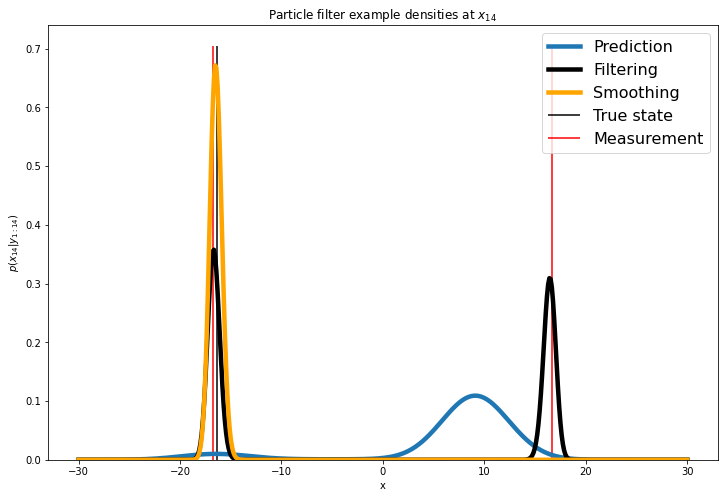

In [4]:
the_particle_filter_example()

# Linear Gaussian dynamics, Student-t observations (5.2)

In [5]:


# functions for student t random walk example

# state transition function
def state_trans_func2(x, v, k=None):
    return x + v


# measurement function
def measure_func2(x, e):
    return x + e


# to get x from measurement without noise
def inv_measure_func2(y):
    return y


# functions to get sample
def v_rvs2(rng_key, shape):
    return random.t(rng_key, df=3, shape=shape)


def e_rvs2(rng_key, shape):
    return random.t(rng_key, df=3, shape=shape)


def x0_rvs2(rng_key, shape):
    return random.t(rng_key, df=3, shape=shape)


# functions to get density
pdf2 = functools.partial(jsp.stats.t.pdf, df=3)
v_pdf2 = pdf2
e_pdf2 = pdf2
x0_pdf2 = pdf2


def student_t_random_walk_example(
    rng_key=random.PRNGKey(0),
    grid_minval=-60,
    grid_maxval=30,
    num_grid_points=500,
    max_iter=25,
    iter_=22,
    plot_all_densities=False):
    # generate data points and densities
    x_grid, x_true, y = experiment_setup(
        rng_key=rng_key, grid_minval=grid_minval, grid_maxval=grid_maxval,
        num_grid_points=num_grid_points, x0_rvs=x0_rvs2, v_rvs=v_rvs2,
        e_rvs=e_rvs2, f=state_trans_func2, h=measure_func2,
        max_iter=max_iter, plot_xy=False,
    )

    p_filter, p_pred, p_smooth = point_mass_density(
        y, x_grid, x0_pdf2,
        x_pdf=x_pdf, v_pdf=v_pdf2, e_pdf=e_pdf2,
        f=state_trans_func2, h=measure_func2,
    )

    if plot_all_densities:
        # looking for weird density plot by plotting all max_iter densities
        plot_densities(
            x_true, y, inv_measure_func2,
            x_grid, p_pred, p_filter,
            p_smooth, max_iter,
        )

    # plot the kth density
    plot_density(
        x_true, y, inv_measure_func2,
        x_grid, p_pred, p_filter,
        p_smooth, k=iter_, legend=True,
        ax=None, title=f"Student's t random walk example densities at $x_{{{iter_}}}$",
    )

    plt.show()



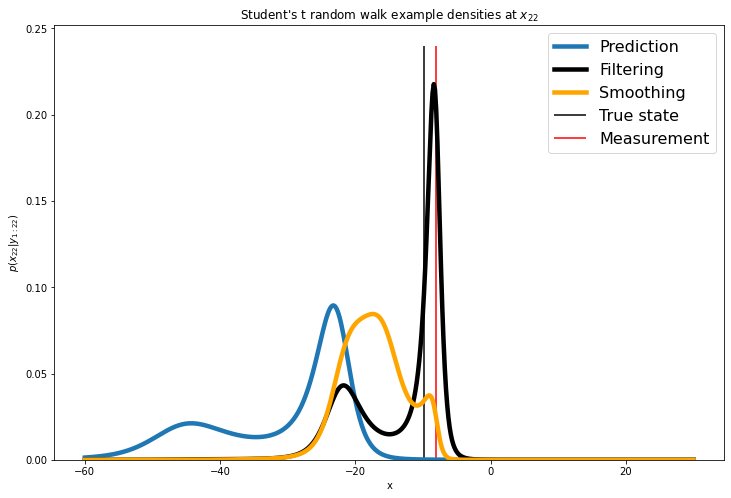

In [6]:
student_t_random_walk_example()

# Saturated measurement with intractable likelihood (sec 5.3)

In [7]:

def inversion_sampling(rng_key, x_grid, px_grid, num_samples):
    rng_keys = random.split(rng_key, num=2)
    u = random.uniform(rng_keys[0], shape=(num_samples, 1))
    delta = x_grid[1] - x_grid[0]
    noise = random.uniform(
        rng_keys[1], minval=-delta / 2, maxval=delta / 2, shape=(num_samples,)
    )
    # It only works for sufficient dense uniformly spaced grid
    point_mass = px_grid

    cdf = jnp.cumsum(point_mass)

    bound_cdf = jnp.where(cdf < u, cdf, 0)
    idx = jnp.argmax(bound_cdf, axis=1)
    x = x_grid[idx]
    return x + noise


def kde(x_grid, x, kernel_variance):
    delta = x_grid[1] - x_grid[0]
    # broadcast it into (n_x_grid, nx)
    x_grid = jnp.tile(x_grid[..., jnp.newaxis], (1, x.shape[0]))
    px = jsp.stats.norm.pdf(x_grid, loc=x, scale=kernel_variance)
    px = jnp.sum(px, axis=1)
    px = px / jnp.sum(px) / delta
    return px


def novel_density(
        rng_key: jnp.DeviceArray, y: jnp.DeviceArray, x_grid: jnp.DeviceArray,
        x0_pdf: Callable, v_rvs: Callable, e_rvs: Callable,
        f: Callable, h: Callable, num_samples: int,
        max_iter: int, kernel_variance: float):
    num_grid_points = x_grid.shape[0]
    delta = x_grid[1] - x_grid[0]

    p_filter = jnp.zeros(shape=(max_iter + 1, num_grid_points))
    p_filter = p_filter.at[0, :].set(x0_pdf(x_grid))
    p_filter = p_filter.at[0, :].set(p_filter[0, :] / jnp.sum(p_filter[0, :]))
    p_pred = jnp.ones(shape=(max_iter + 1, num_grid_points)) * jnp.inf
    rng_keys = random.split(rng_key, num=3)
    v = v_rvs(rng_keys[0], shape=(max_iter + 1, num_samples))
    e = e_rvs(rng_keys[1], shape=(max_iter + 1, num_samples))

    for k in range(1, max_iter + 1):
        x = inversion_sampling(
            rng_keys[2],
            x_grid,
            p_filter[k - 1, :],
            num_samples=num_samples,
        )

        x = f(x, v[k], k - 1)

        # p(xk | y(1:k-1))
        p_pred = p_pred.at[k, :].set(kde(x_grid, x, kernel_variance))
        p_pred = p_pred.at[k, :].set(p_pred[k, :] / jnp.sum(p_pred[k, :]))

        # measurement
        y = h(x, e[k])

        # p(xk | y(1:k))
        threshold = 3 * jnp.sqrt(kernel_variance)
        distance = jnp.abs(y[k] - y)

        def update(xi, yi, distance_i):
            return jnp.where(
                distance_i < threshold,
                jsp.stats.norm.pdf(x_grid, xi, kernel_variance)
                * jsp.stats.norm.pdf(y[k], yi, kernel_variance),
                0,
            )

        update_vals = jax.vmap(update)(x, y, distance)
        p_filter = p_filter.at[k, :].set(p_filter[k, :] + jnp.sum(update_vals, axis=0))
        p_filter = p_filter.at[k, :].set(p_filter[k, :] / jnp.sum(p_filter[k, :]))
    return p_filter / delta, p_pred / delta



In [8]:

# functions for saturated measurements example

# state transition function
def state_trans_func3(x, v, k=None):
    return 0.7 * x + v


# measurement function
def saturate(x, minval, maxval):
    return jnp.maximum(jnp.minimum(x, maxval), minval)


def measure_func3(x, e, minval=-1.5, maxval=1.5):
    return saturate(x + e, minval=minval, maxval=maxval)


# to get x from measurement without noise
def inv_measure_func3(y):
    return y


# functions to get sample
def v_rvs3(rng_key, shape):
    return random.normal(rng_key, shape=shape)


def e_rvs3(rng_key, shape):
    return random.normal(rng_key, shape=shape) * jnp.sqrt(0.5)


def x0_rvs3(rng_key, shape):
    return random.normal(rng_key, shape=shape) * jnp.sqrt(0.1)


# functions to get density
x0_pdf3 = functools.partial(jsp.stats.norm.pdf, scale=jnp.sqrt(0.1))


def saturated_measurements_example(
    rng_key=random.PRNGKey(0),
    num_samples=10000,
    grid_minval=-6,
    grid_maxval=6,
    num_grid_points=500,
    max_iter=24,
    iter_=18,
    plot_all_densities=False):
    # generate data points and densities
    rng_key, subkey = random.split(rng_key, num=2)
    x_grid, x_true, y = experiment_setup(
        rng_key=rng_key, grid_minval=grid_minval, grid_maxval=grid_maxval,
        num_grid_points=num_grid_points, x0_rvs=x0_rvs3, v_rvs=v_rvs3,
        e_rvs=e_rvs3, f=state_trans_func3, h=measure_func3,
        max_iter=max_iter, plot_xy=True,
    )

    p_filter, p_pred = novel_density(
        subkey, y, x_grid,
        x0_pdf3, v_rvs3, e_rvs3,
        state_trans_func3, measure_func3, num_samples,
        max_iter, kernel_variance=0.15,
    )
    p_smooth = None

    if plot_all_densities:
        # looking for weird density plot by plotting all max_iter densities
        plot_densities(
            x_true, y, inv_measure_func3,
            x_grid, p_pred, p_filter,
            p_smooth, max_iter,
        )

    # plot the kth density
    plot_density(
        x_true, y, inv_measure_func3,
        x_grid, p_pred, p_filter,
        p_smooth, k=iter_, legend=True,
        ax=None, title=f"Saturated measurements example densities at $x_{{{iter_}}}$",
    )

    plt.show()




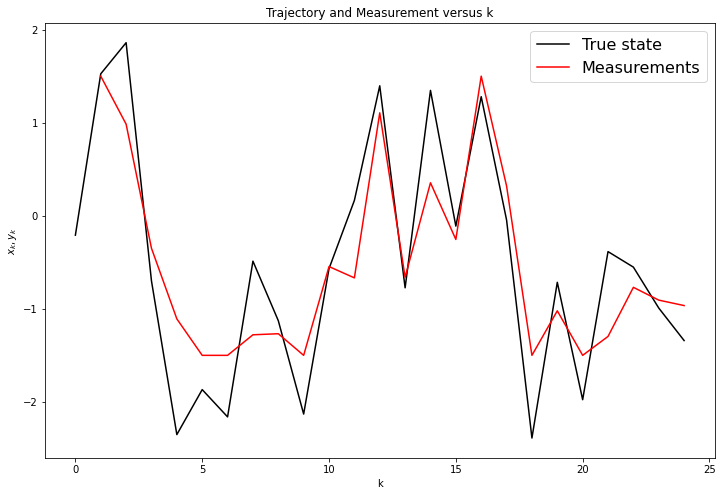

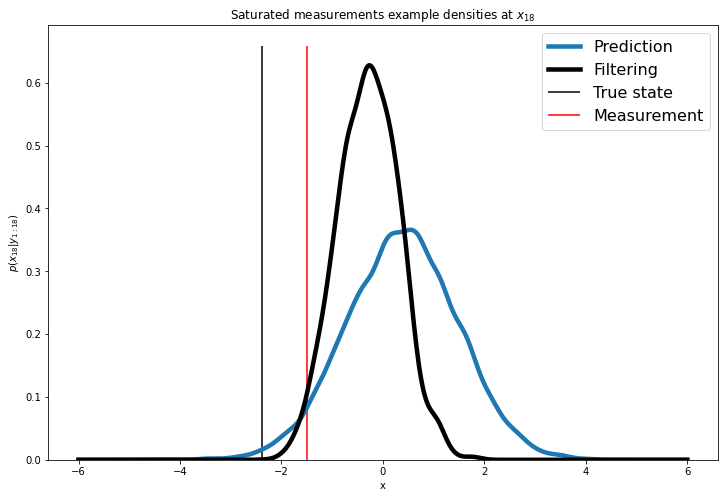

In [9]:
saturated_measurements_example()